# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df = df.drop(['RowNumber','CustomerId', 'Surname'], axis=1)

In [4]:
df_Nan = df.query('Tenure == "nan"')
df_Nan['Exited'].value_counts()

0    726
1    183
Name: Exited, dtype: int64

In [5]:
print(df['Tenure'].unique())
dfN = df.query('Tenure != "nan"')
df['Tenure'] = df['Tenure'].fillna(dfN['Tenure'].median())
print(df['Tenure'].unique())

[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan]
[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0.]


### Вывод:

Столбцы 'RowNumber','CustomerId', 'Surname' для обучения модели не нужны (даже вредны), потомучто являются строго индивидуальными "маркерами" людей, и из них нельзя "выдавить" никаких статистических закономерностей. С т.з. нормального здравого смысла наличие связи между фамилией и финансовым поведением человека если и есть, то она ничтожно мала, а для конкретной узкой задачи с колличеством записей всего в 10000 врядли может проявиться. Поэтому избавлемся от этих столбцов.
Пропуски по столбцу 'Tenure' состовляют 10 %, и, судя по целевому признаку'Exited', соотношение классов в них примерно такое же, как в остальной части датасета. Поэтому можно либо удалить их, либо значение пропусков заменить на медианное значение без особых потерь в плане обучения модели. Второе предпочтительнее.

# 2. Исследование задачи

0    0.7963
1    0.2037
Name: Exited, dtype: float64


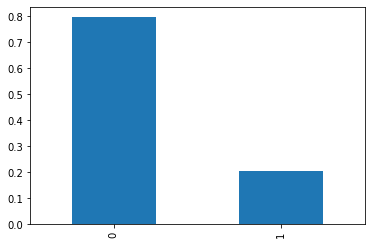

In [6]:
class_frequency = df['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

In [7]:
df = pd.get_dummies(df)
print(pd.get_dummies(df).head())

   CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42     2.0       0.00              1          1   
1          608   41     1.0   83807.86              1          0   
2          502   42     8.0  159660.80              3          1   
3          699   39     1.0       0.00              2          0   
4          850   43     2.0  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_France  \
0               1        101348.88       1                 1   
1               1        112542.58       0                 0   
2               0        113931.57       1                 1   
3               0         93826.63       0                 1   
4               1         79084.10       0                 0   

   Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  
0                  0                0              1            0  
1                  0                1              1            0  
2 

In [8]:
df_learn, df_test = train_test_split(df, test_size=0.20, random_state=12345)

features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

target_learn = df_learn['Exited']
features_learn = df_learn.drop('Exited', axis=1)

In [9]:
target_pred_constant = pd.Series(0, index = target_learn.index)
print(accuracy_score(target_learn, target_pred_constant))

0.79875


In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_learn, target_learn, test_size=0.25, random_state=12345)

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
print(features_train.head())

      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
492     -0.134048 -0.078068 -0.369113  0.076163              2          0   
6655    -1.010798  0.494555 -0.007415  0.136391              1          1   
4287     0.639554  1.353490 -1.454209  0.358435              1          1   
42      -0.990168  2.116987 -1.092511  0.651725              1          1   
8178     0.567351  0.685430  0.715982  0.813110              2          1   

      IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
492                1         0.331571                 1                  0   
6655               1        -0.727858                 1                  0   
4287               1        -0.477006                 0                  1   
42                 1        -0.100232                 1                  0   
8178               1         0.801922                 1                  0   

      Geography_Spain  Gender_Female  Gender_Male  
492             

In [13]:
model = DecisionTreeClassifier(random_state=12345)

model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.4879898862199747


In [14]:
model = LogisticRegression(random_state=12345, solver='liblinear')

model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.30131826741996237


In [15]:
model = RandomForestClassifier(random_state=12345)

model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.5138211382113821


### Выводы:

Дисбаланс достаточно большой, разница примерно в четыре раза. Невозможно будет оценить адекватность модели, т.к. метрики (например accuracy_score) будут демонстрировать высокие значения, при том что в качестве предсказаний для расчёта метрики будет предложен объект Series с одинаковыми значениями одного из классов (в данном случае "0").  Поэтому необходимо применить техники преобразование выборок.

Наиболее высокое значение F1-меры демострирует RandomForestClassifier. Продолжим работать с ним.

# 3. Борьба с дисбалансом

In [16]:
from sklearn.utils import shuffle
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [17]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

1    0.504919
0    0.495081
Name: Exited, dtype: float64


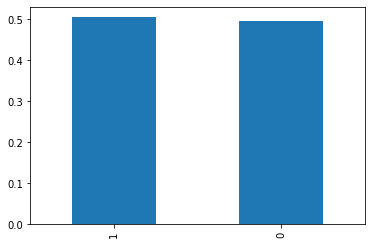

In [18]:
class_frequency = target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

In [19]:
for n in range(1, 100, 5):
    model = RandomForestClassifier(random_state=12345, n_estimators=n, max_depth=13)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('n=', n, "F1:", f1_score(target_valid, predicted_valid))

n= 1 F1: 0.4319526627218935
n= 6 F1: 0.5483476132190942
n= 11 F1: 0.5541871921182266
n= 16 F1: 0.5795314426633785
n= 21 F1: 0.5895249695493301
n= 26 F1: 0.5888198757763975
n= 31 F1: 0.5930521091811415
n= 36 F1: 0.592039800995025
n= 41 F1: 0.5882352941176471
n= 46 F1: 0.592964824120603
n= 51 F1: 0.5830164765525981
n= 56 F1: 0.5904522613065326
n= 61 F1: 0.5889724310776941
n= 66 F1: 0.5922208281053952
n= 71 F1: 0.5843828715365238
n= 76 F1: 0.585
n= 81 F1: 0.5877957658779576
n= 86 F1: 0.59
n= 91 F1: 0.5917602996254682
n= 96 F1: 0.5950000000000001


In [20]:
for depth in range(16, 29, 1):
    model = RandomForestClassifier(random_state=12345, n_estimators=96, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print('depth', depth, "F1:", f1_score(target_valid, predicted_valid))

depth 16 F1: 0.5792349726775957
depth 17 F1: 0.5975103734439834
depth 18 F1: 0.5782122905027932
depth 19 F1: 0.6072423398328691
depth 20 F1: 0.5915492957746479
depth 21 F1: 0.5887323943661972
depth 22 F1: 0.5867418899858956
depth 23 F1: 0.5801952580195258
depth 24 F1: 0.5793871866295264
depth 25 F1: 0.5850914205344585
depth 26 F1: 0.5827439886845828
depth 27 F1: 0.584958217270195
depth 28 F1: 0.5810055865921788


In [21]:
model = RandomForestClassifier(random_state=12345, n_estimators=96, max_depth=19)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6072423398328691


In [22]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

1    0.504971
0    0.495029
Name: Exited, dtype: float64


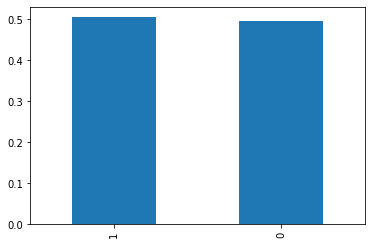

In [23]:
class_frequency = target_downsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

##### downsampling

In [24]:
model = RandomForestClassifier(random_state=12345, n_estimators=96, max_depth=13)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5624404194470924


##### upsampling

In [25]:
model = RandomForestClassifier(random_state=12345, n_estimators=96, max_depth=13)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5950000000000001


### Вывод:

Лучшее значение метрики F1-меры показала модель RandomForestClassifier, обученная на данных, полученных после upsampling'а класса "1" (т.е. приведение баланса классов путём увеличение колличества "виртуальных объектов" - увеличение колличества "фактов уходов клиентов" c параметрами n_estimators=96 и max_depth=13

# 4. Тестирование модели

In [26]:
model = RandomForestClassifier(random_state=12345, n_estimators=96, max_depth=13)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.6161137440758294


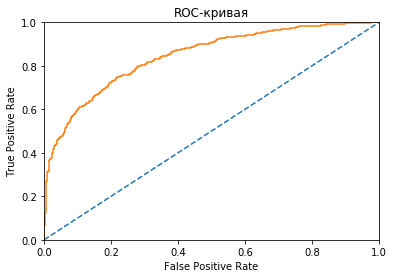

In [27]:
from sklearn.metrics import roc_curve

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [28]:
import numpy as np
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8450404454483175


### Вывод:

Лучшее значение метрики F1-меры показала модель RandomForestClassifier c параметрами n_estimators=96 и max_depth=13.
Метрика *AUC-ROC* лучше чем у случайной модели, но до идеального (AUC-ROC = 1) достаточно далеко.